# Project  :  Movie_Revenue_and_Rating_Predictor

## Load the data

The dataset was generated from The Movie Database API.

In [1]:
import json
import cpi
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, to_graphviz,plot_importance
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Load the movies

In [2]:
movie_path = "Raw_Data/tmdb_5000_movies.xlsx"

In [3]:
movie_df = pd.read_excel(movie_path)
movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bondâ€™s past sends him...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
movie_df.dtypes

budget                           int64
genres                          object
homepage                        object
id                               int64
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
dtype: object

In [5]:
movie_df.describe()

,budget,id,popularity,release_date,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4802,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,2002-12-27 23:45:54.352353280,8.226064e+07,106.875859,6.092172,690.217989
min,0.000000e+00,5.000000,0.000000,1916-09-04 00:00:00,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,1999-07-14 00:00:00,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,2005-10-03 00:00:00,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,2011-02-16 00:00:00,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2017-02-03 00:00:00,2.787965e+09,338.000000,10.000000,13752.000000
std,4.072239e+07,88694.614033,31.816650,NaN,1.628571e+08,22.611935,1.194612,1234.585891


<Axes: >

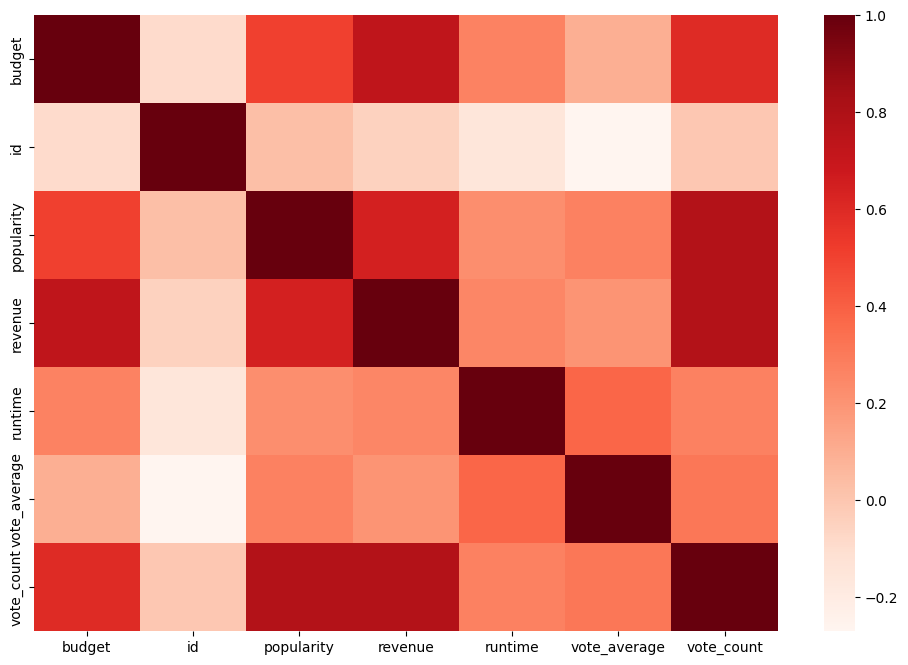

In [6]:
corr=movie_df[['budget','id','popularity','revenue','runtime','vote_average','vote_count']].corr()
fig, ax =plt.subplots(figsize=(12,8))
sns.heatmap(corr, cmap="Reds",
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=False   )

### Null values

In [7]:
movie_df.apply(lambda x: sum(x.isna()),axis=0)

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

We are not interested in the features homepage and tagline so we will drop them later

#### Runtime null values

In [8]:
movie_df.loc[movie_df.runtime.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0


We set them to the mean runtime

In [9]:
movie_df.runtime.fillna(movie_df.runtime.mean(),inplace=True)

Release date null value

In [10]:
movie_df.loc[movie_df.release_date.isnull()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaT,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0


Data is useless so we drop it

In [11]:
movie_df= movie_df.loc[movie_df.release_date.notnull()]

#### Overview null values

We don't really use the overview feature, but we can easily fix the null values

In [12]:
movie_df.overview.fillna("Unspecified",inplace=True)

### Zero values

In [13]:
movie_df.apply(lambda x: sum(x==0),axis=0)

budget                  1036
genres                     0
homepage                   0
id                         0
keywords                   0
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                 1426
runtime                   34
spoken_languages           0
status                     0
tagline                    0
title                      0
vote_average              62
vote_count                61
dtype: int64

#### Revenue and budget

Since our primary objective is predicting revenue, we will drop the zero valued revenues and budgets

In [14]:
outlier_thresh=1000
movie_df=movie_df[movie_df.budget>outlier_thresh]
movie_df=movie_df[movie_df.revenue>outlier_thresh]
len(movie_df)

3211

In [15]:
zero_vals=movie_df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

vote_average    2
vote_count      2
dtype: int64

#### Vote count and average

In [16]:
movie_df=movie_df[movie_df.vote_count>0]

In [17]:
zero_vals=movie_df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

Series([], dtype: int64)

No more zero values

### JSON Handling

We still have some columns in json format 

In [18]:
columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']

for col in columns: 
    movie_df[col] = movie_df[col].apply(json.loads)

movie_df['release_date'] =  pd.to_datetime(movie_df['release_date'], format ='%Y-%m-%d')

In [19]:
movie_df['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

A movie can have several genres.

In [20]:
movie_df['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [21]:
# We extract the names from the json data
for col in columns: 
    movie_df[col] = movie_df[col].map(lambda x:[i['name'] for i in x])

movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bondâ€™s past sends him...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124


We extract year, month and day of year from release date

In [22]:
movie_df['year'] = movie_df['release_date'].map(lambda dates: dates.year)

In [23]:
movie_df['release_date'] = movie_df['release_date'].map(lambda dates: datetime.datetime.strptime(str(dates), '%Y-%m-%d %H:%M:%S'))
movie_df['day_of_year'] = movie_df['release_date'].map(lambda dates: dates.timetuple().tm_yday)

movie_df['year'] = movie_df['release_date'].map(lambda dates: dates.year)

In [24]:
movie_df['month'] = movie_df['release_date'].map(lambda dates: dates.month)

## EDA 

### Movie title

In [25]:
count_title = movie_df.groupby('title').title.count()
count_title[count_title != 1]

title
The Host    2
Name: title, dtype: int64

Some movies have the same title, so we make the title unique by appending the release year

In [26]:
double_title = count_title[count_title != 1].index.values

In [27]:
movie_df.title = movie_df.apply(lambda row: row.title+'_'+str(row.release_date) if (row.title in double_title) else row.title,axis = 1)

In [28]:
count_title = movie_df.groupby('title').title.count()
count_title[count_title != 1]

Series([], Name: title, dtype: int64)

### Movies budget

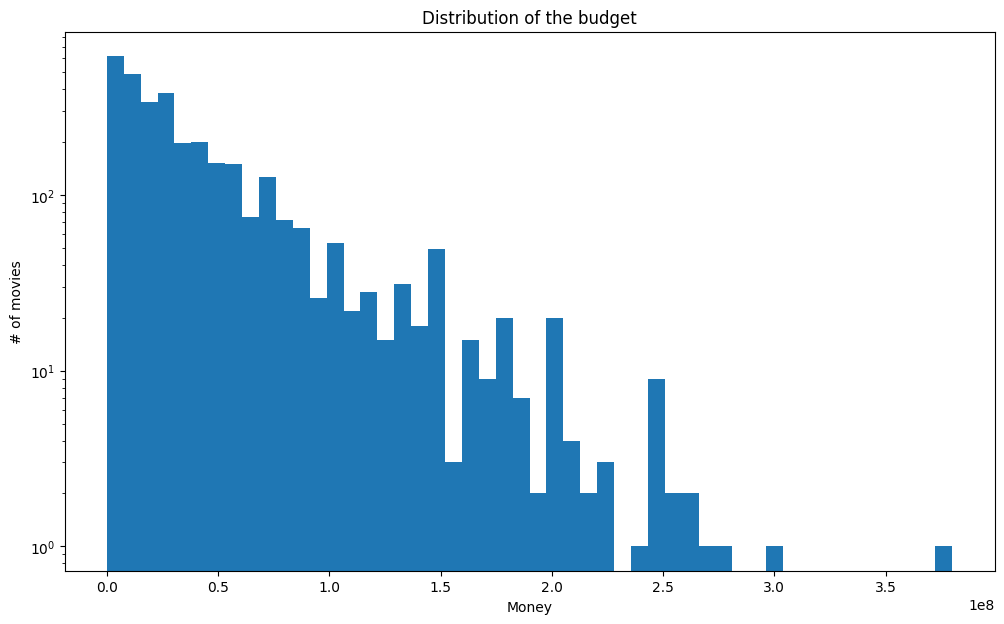

In [29]:
plt.figure(figsize=(12,7))
plt.hist(movie_df['budget'],bins= 50)
plt.title("Distribution of the budget")
plt.xlabel('Money')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

### Revenue

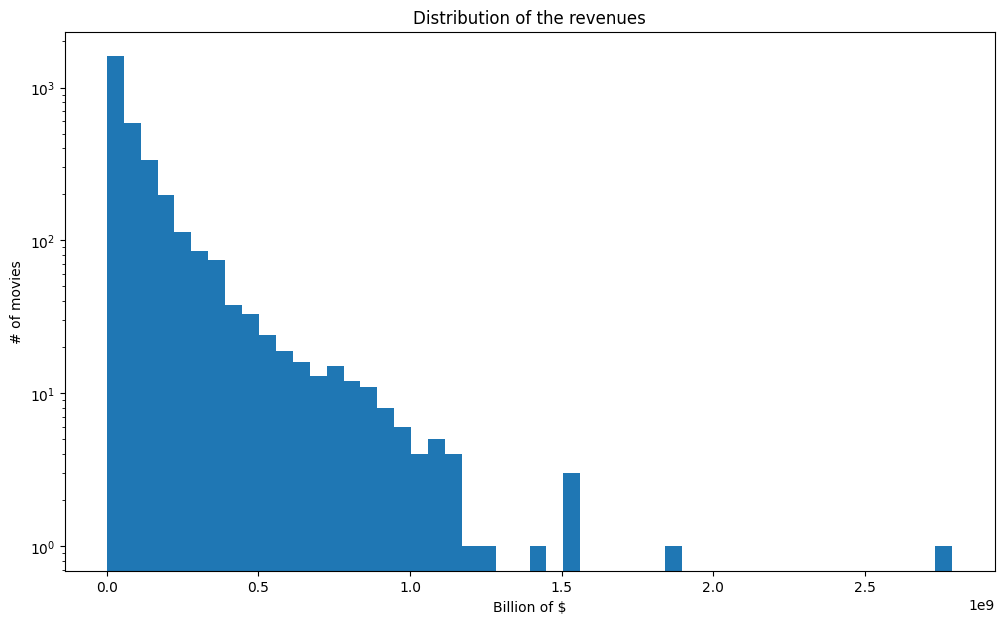

In [30]:
plt.figure(figsize=(12,7))
plt.hist(movie_df['revenue'], bins= 50)
plt.title("Distribution of the revenues")
plt.xlabel('Billion of $')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

### Genres

In [31]:
df_genres = movie_df.explode('genres')
df_genres.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,day_of_year,month
0,237000000,Action,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Adventure,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Fantasy,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
0,237000000,Science Fiction,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12
1,300000000,Adventure,http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",...,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,139,5


In [32]:
df_genres.genres.unique()

array(['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', nan], dtype=object)

In [33]:
count_genres = df_genres.groupby('genres').count()[['id']].sort_values(by='id', ascending=False)
count_genres.head()

,id
genres,
Drama,1428
Comedy,1101
Thriller,930
Action,915
Adventure,660


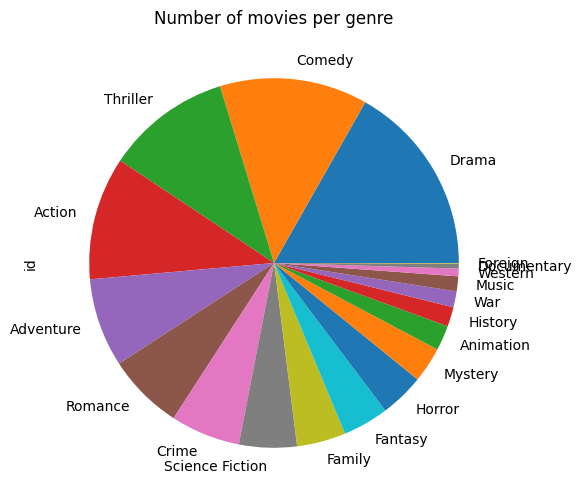

In [34]:
count_genres.plot(kind ='pie',figsize=(10,6),legend = False, subplots = True)
plt.title('Number of movies per genre')
plt.show()

What genre make the most money ?

In [35]:
df_genres_revenue = movie_df[['genres','revenue']].explode('genres')
df_genres_revenue.head()

,genres,revenue
0,Action,2787965087
0,Adventure,2787965087
0,Fantasy,2787965087
0,Science Fiction,2787965087
1,Adventure,961000000


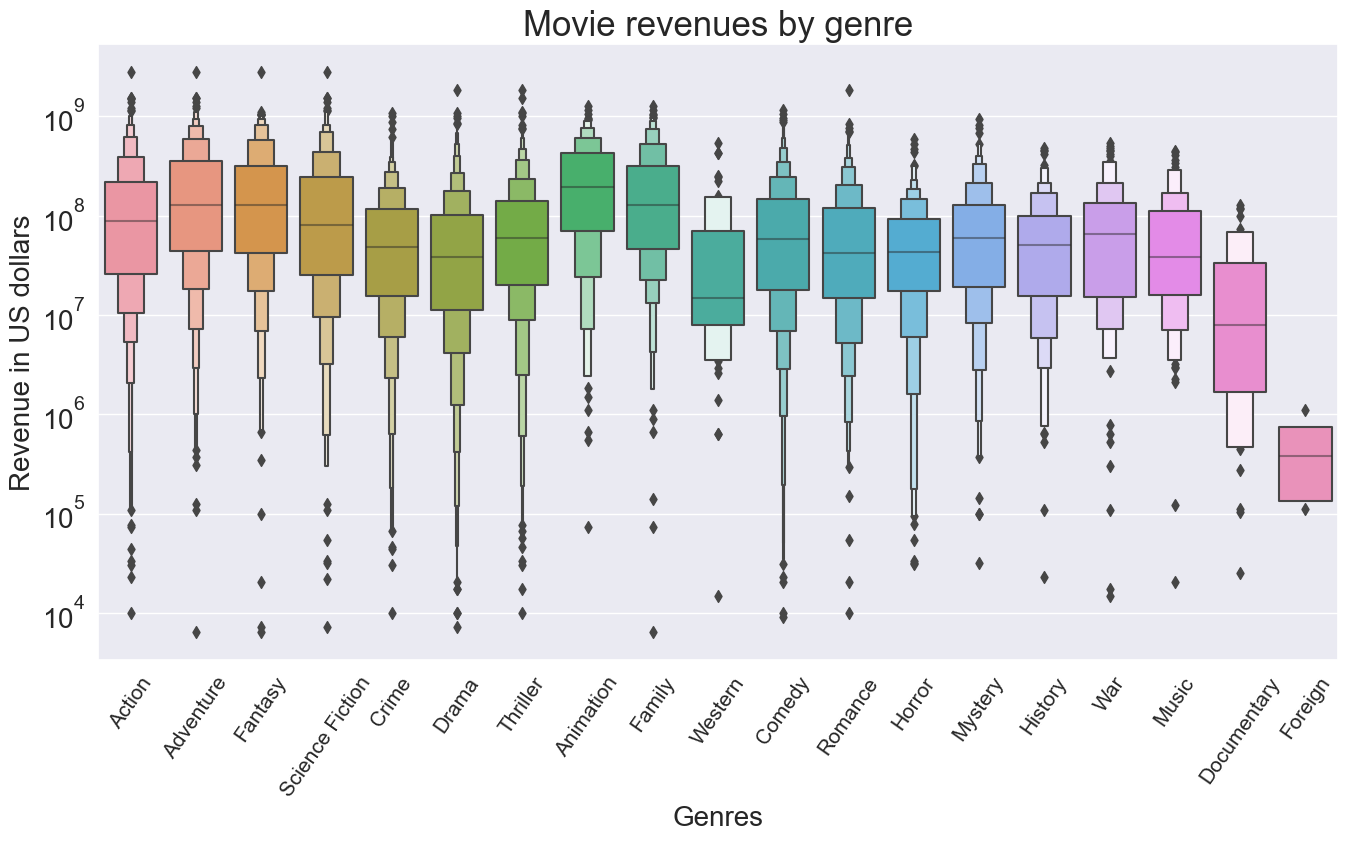

In [36]:
sns.set(style="darkgrid")
f,ax=plt.subplots(figsize=(16, 8))
sns.boxenplot(data=df_genres_revenue[df_genres_revenue["revenue"]>0].reset_index(),x="genres",y="revenue")
plt.yticks(fontsize=20)
plt.yscale("log")
plt.xticks(rotation=55,fontsize=15)
plt.xlabel("Genres",fontsize=20)
plt.ylabel("Revenue in US dollars",fontsize=20)
plt.title("Movie revenues by genre",fontsize=25)
plt.show()

In [37]:
df_genres_revenue = df_genres_revenue.groupby('genres')[['revenue']].sum()
df_genres_revenue.head()

,revenue
genres,
Action,162316088206
Adventure,163667924225
Animation,52436463168
Comedy,120403594524
Crime,45797218000


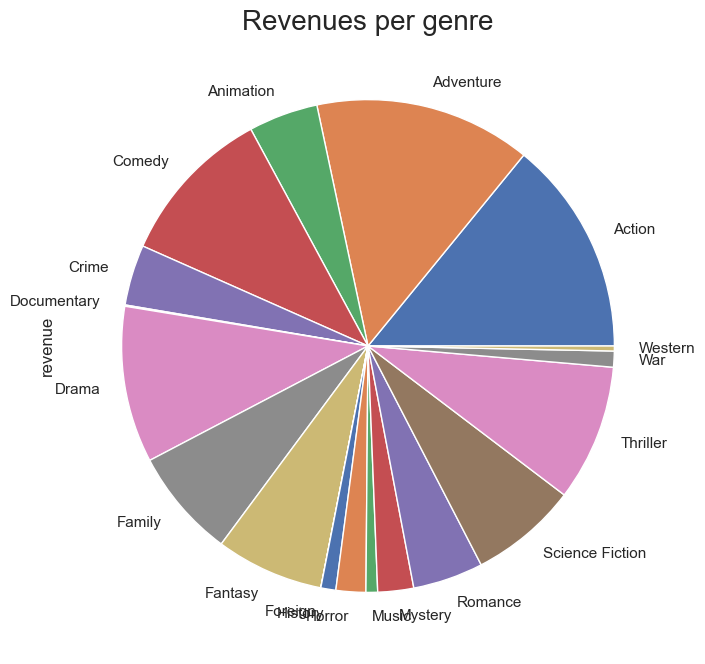

In [38]:

df_genres_revenue.plot(kind ='pie',figsize=(16,8),legend = False, subplots = True)
plt.title('Revenues per genre',fontsize=20)
plt.show()

In [39]:
df_genres_grade = movie_df[['genres','vote_average']].explode('genres')
df_genres_grade.head()

,genres,vote_average
0,Action,7.2
0,Adventure,7.2
0,Fantasy,7.2
0,Science Fiction,7.2
1,Adventure,6.9


In [40]:
df_genres_grade.shape

(8509, 2)

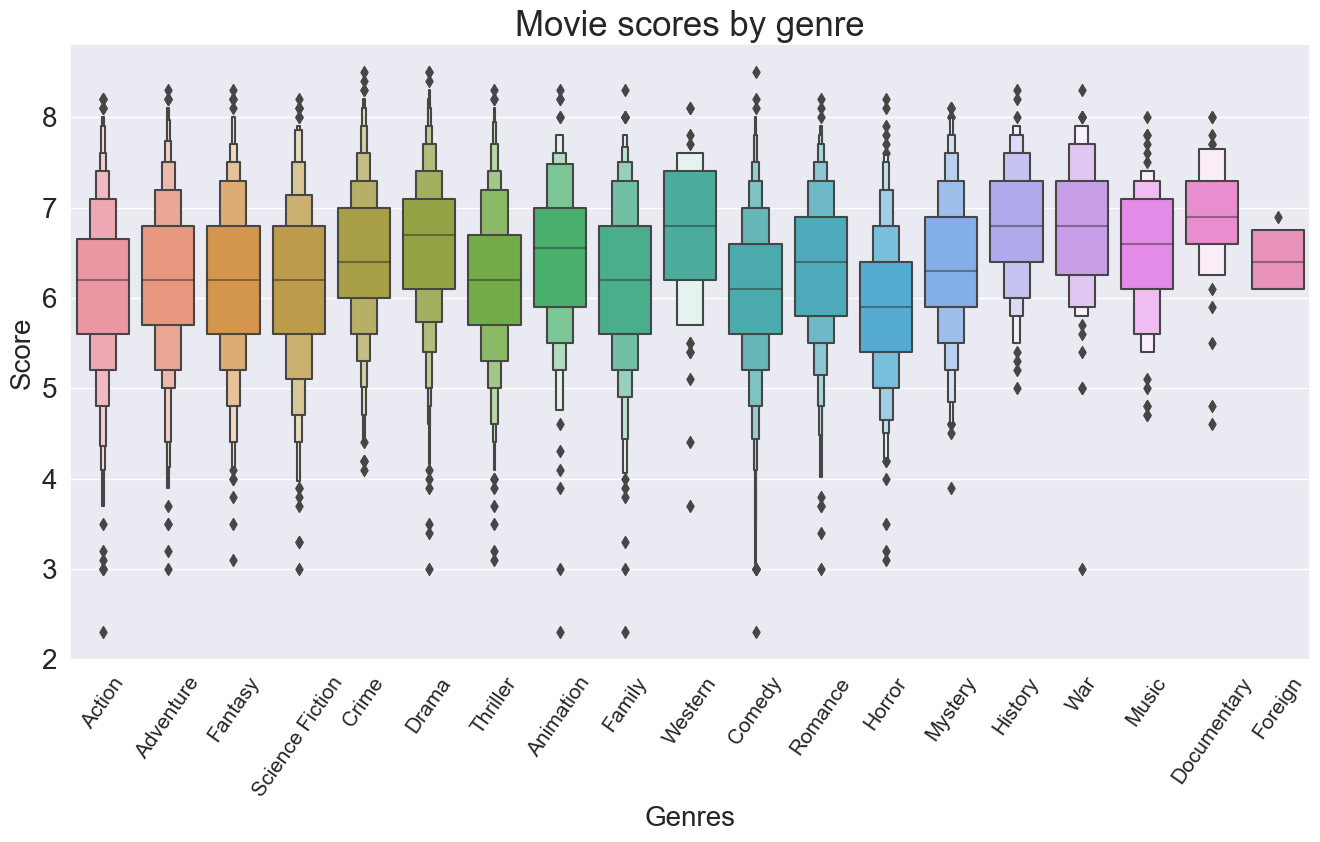

In [41]:
sns.set(style="darkgrid")
f,ax=plt.subplots(figsize=(16, 8))
sns.boxenplot(data=df_genres_grade,x="genres",y="vote_average")
plt.yticks(fontsize=20)
plt.xticks(rotation=55,fontsize=15)
plt.xlabel("Genres",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Movie scores by genre",fontsize=25)
plt.show()

### Popularity 

Metric computed by TMDB and taking into account : 

* Number of votes for the day
* Number of views for the day
* Number of users who marked it as a "favourite" for the day
* Number of users who added it to their "watchlist" for the day
* Release date
* Number of total votes
* Previous days score

In [42]:
df_movie_pop = movie_df[['title','popularity']].sort_values(by='popularity', ascending=False)
df_movie_pop.head()

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564


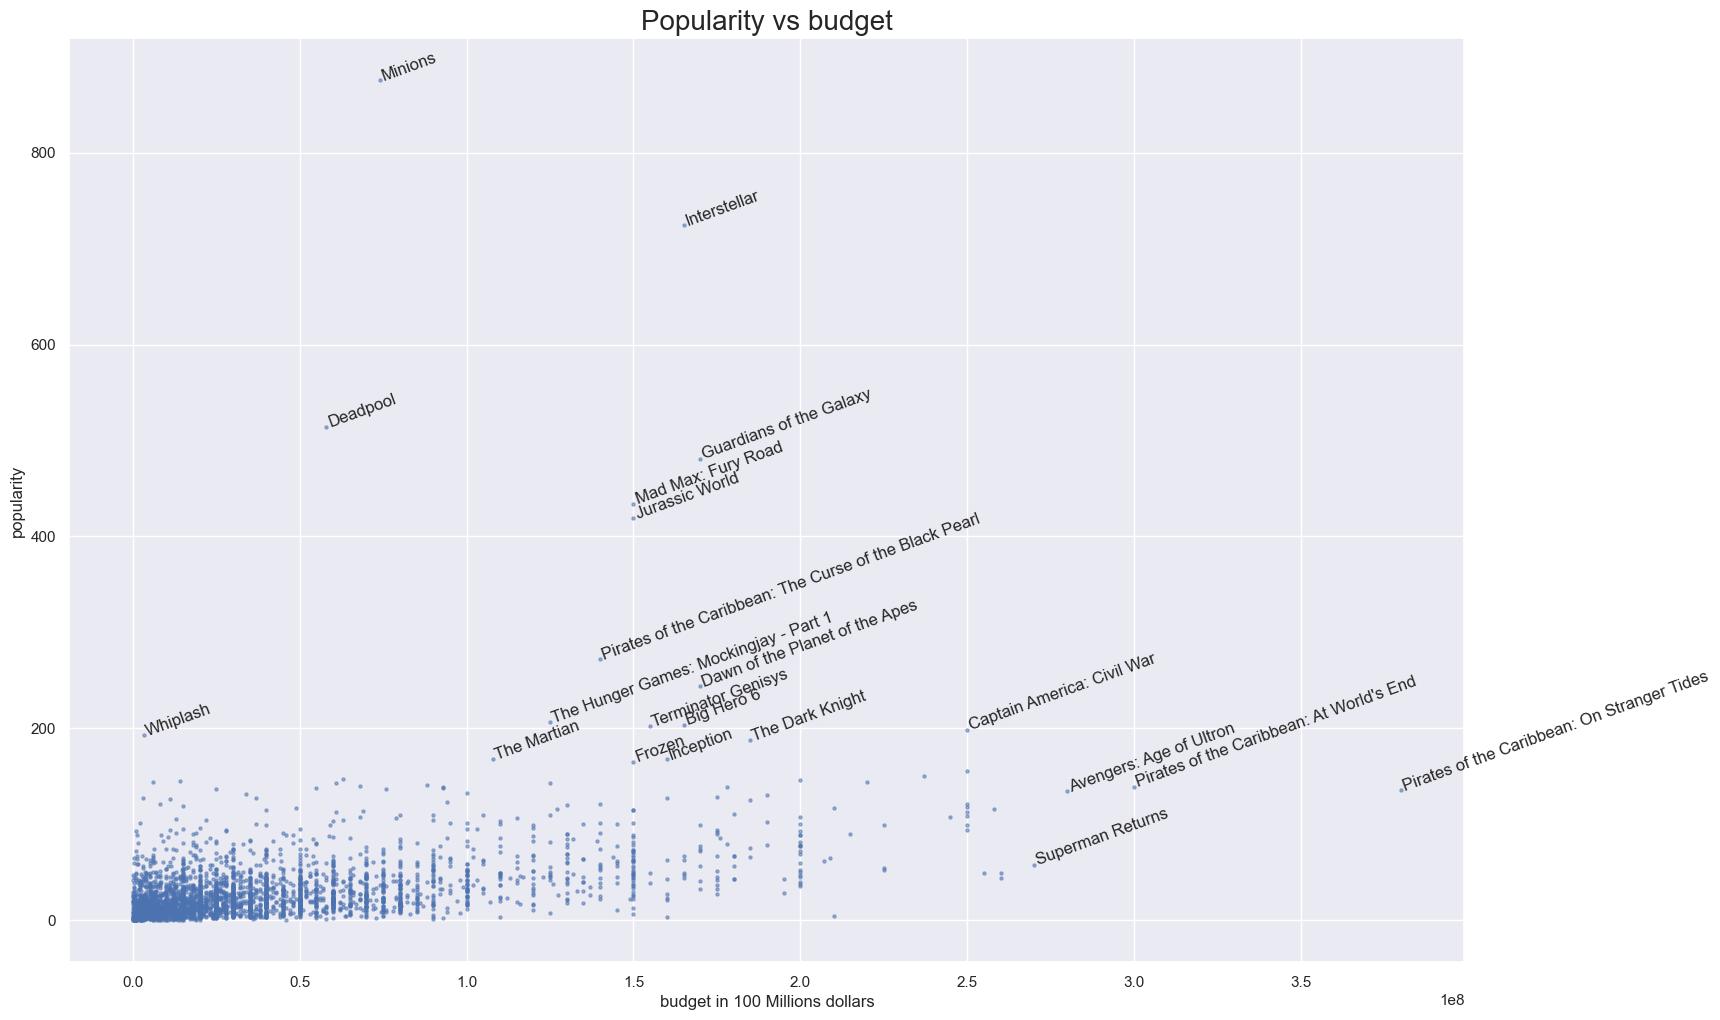

In [43]:
x=movie_df["budget"]
y=movie_df["popularity"]
fig,ax=plt.subplots(figsize=(18,12))
plt.scatter(x,y,alpha=0.5,s=5)
plt.title("Popularity vs budget",fontsize=20)
plt.xlabel("budget in 100 Millions dollars")
plt.ylabel("popularity")
for index , row in movie_df.iterrows():
    x=row["budget"]
    y=row["popularity"]
    if((500000000>x>260000000) | (y>160)):
        plt.annotate(row["title"],xy=(x,y),rotation=20)

### Revenue Timeline

In [44]:
df_movie_revenue = movie_df[['title','revenue','release_date']].set_index('release_date').sort_values(by='revenue', ascending=False)
df_movie_revenue.head()

,title,revenue
release_date,,
2009-12-10,Avatar,2787965087
1997-11-18,Titanic,1845034188
2012-04-25,The Avengers,1519557910
2015-06-09,Jurassic World,1513528810
2015-04-01,Furious 7,1506249360


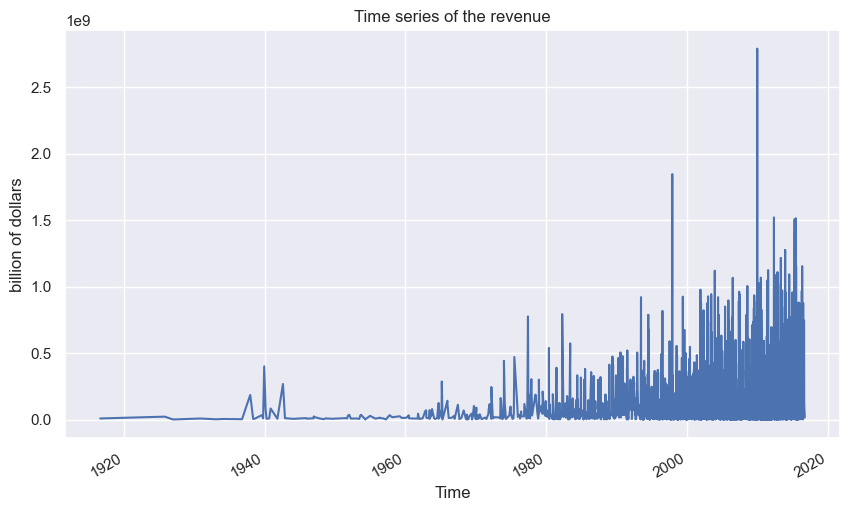

In [45]:
df_movie_revenue.plot(figsize=(10,6),legend = False)
plt.title('Time series of the revenue')
plt.xlabel("Time")
plt.ylabel("billion of dollars")
plt.show()

In [46]:
df_genres_revenue_year = movie_df[['genres','revenue','year']].explode('genres').groupby(['genres','year']).sum()
df_genres_revenue_year.head()

revenue
genres year          
Action 1930   8000000
       1936   2736000
       1949   7800000
       1950   8000000
       1952  36000000

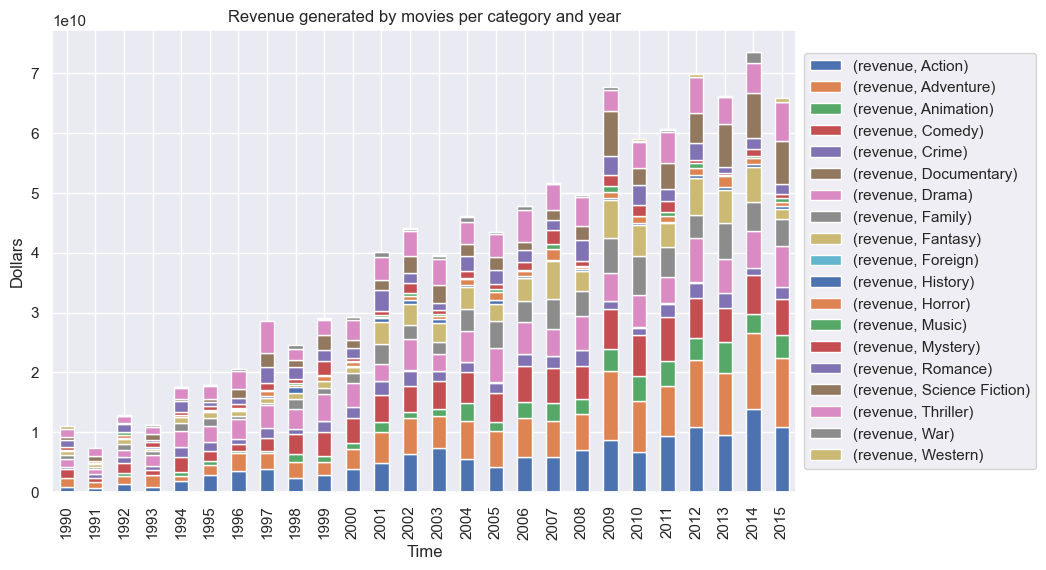

In [47]:
fig = plt.figure()
ax = plt.subplot(111)

starting_year = 1990
df_genres_revenue_year = movie_df[['genres','revenue','year']].explode('genres').groupby(['genres','year']).sum()
df_genres_revenue_year.unstack(level=0).fillna(0).loc[starting_year:2015].plot(kind = 'bar',stacked=True, ax=ax, figsize=(12,6),legend  = True)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Revenue generated by movies per category and year')
plt.ylabel('Dollars')
plt.xlabel('Time')
plt.show()

#### Adjusting to inflation

In [48]:
movie_df.year.describe()

count    3209.000000
mean     2001.722032
std        13.198112
min      1916.000000
25%      1998.000000
50%      2005.000000
75%      2010.000000
max      2016.000000
Name: year, dtype: float64

In [49]:
movie_df["budget_adjusted"]=movie_df.apply(lambda x: cpi.inflate(x["budget"],x["year"],to=2016),axis=1)
movie_df["revenue_adjusted"]=movie_df.apply(lambda x: cpi.inflate(x["revenue"],x["year"],to=2016),axis=1)

In [50]:
df_movie_revenue_adjusted = movie_df[['title','revenue_adjusted','release_date']].set_index('release_date').sort_values(by='revenue_adjusted', ascending=False)
df_movie_revenue_adjusted.head()

,title,revenue_adjusted
release_date,,
1939-12-15,Gone with the Wind,6.909723e+09
1942-08-14,Bambi,3.937987e+09
2009-12-10,Avatar,3.118954e+09
1937-12-20,Snow White and the Seven Dwarfs,3.082181e+09
1977-05-25,Star Wars,3.070973e+09


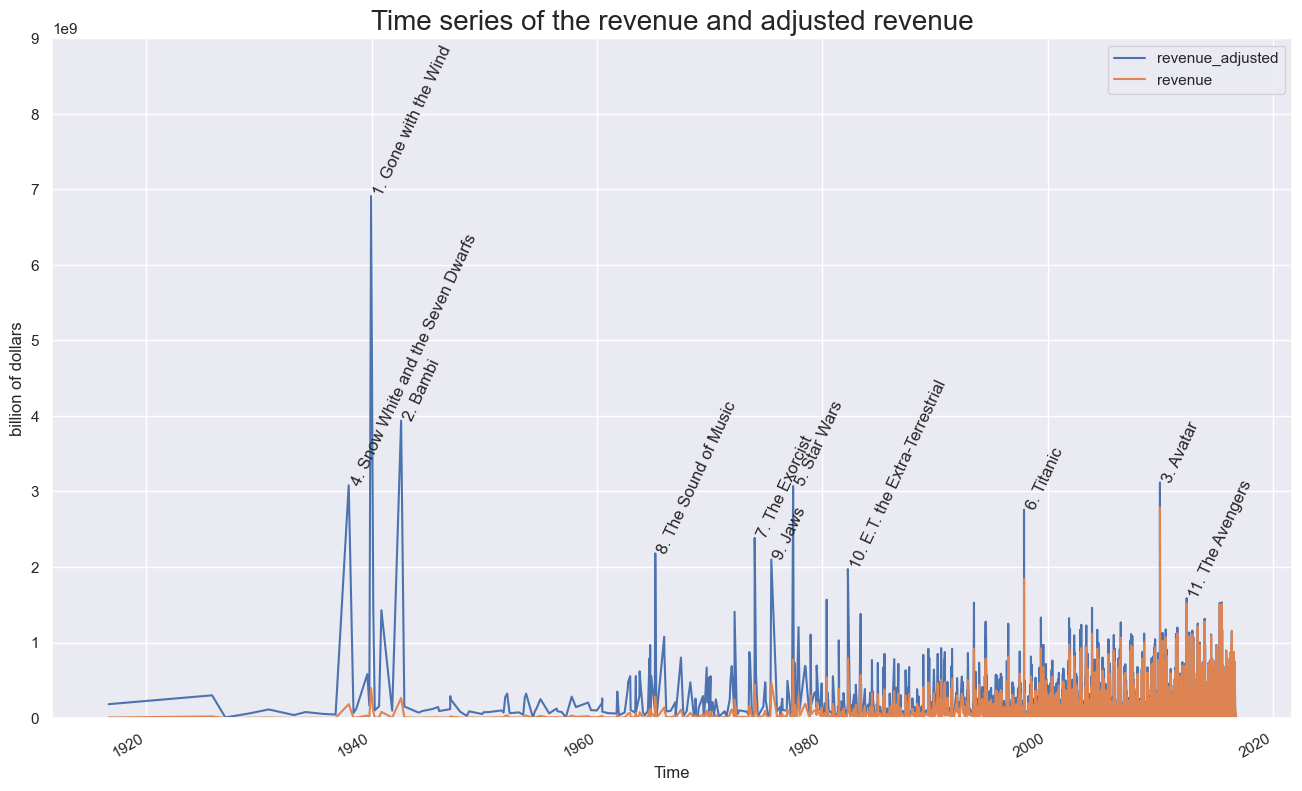

In [51]:
#plt.plot(df_movie_revenue.index,df_movie_revenue["revenue"])
#plt.plot(df_movie_revenue.index,df_movie_revenue_adjusted["revenue_adjusted"])
df_movie_revenue_adjusted.reset_index(
    ).merge(df_movie_revenue,how="inner").set_index("release_date").sort_index().drop(columns=["title"]).plot(figsize=(16,10))
plt.title('Time series of the revenue and adjusted revenue',fontsize=20)
plt.xlabel("Time")
plt.ylabel("billion of dollars")
plt.ylim(0,9e9)
i=0
for index , row in df_movie_revenue_adjusted[:11].iterrows():
    i+=1
    y=row["revenue_adjusted"]
    plt.annotate(str(i)+". "+row["title"],xy=(index,y),rotation=65,xytext=(index,y+10000000))
plt.show()

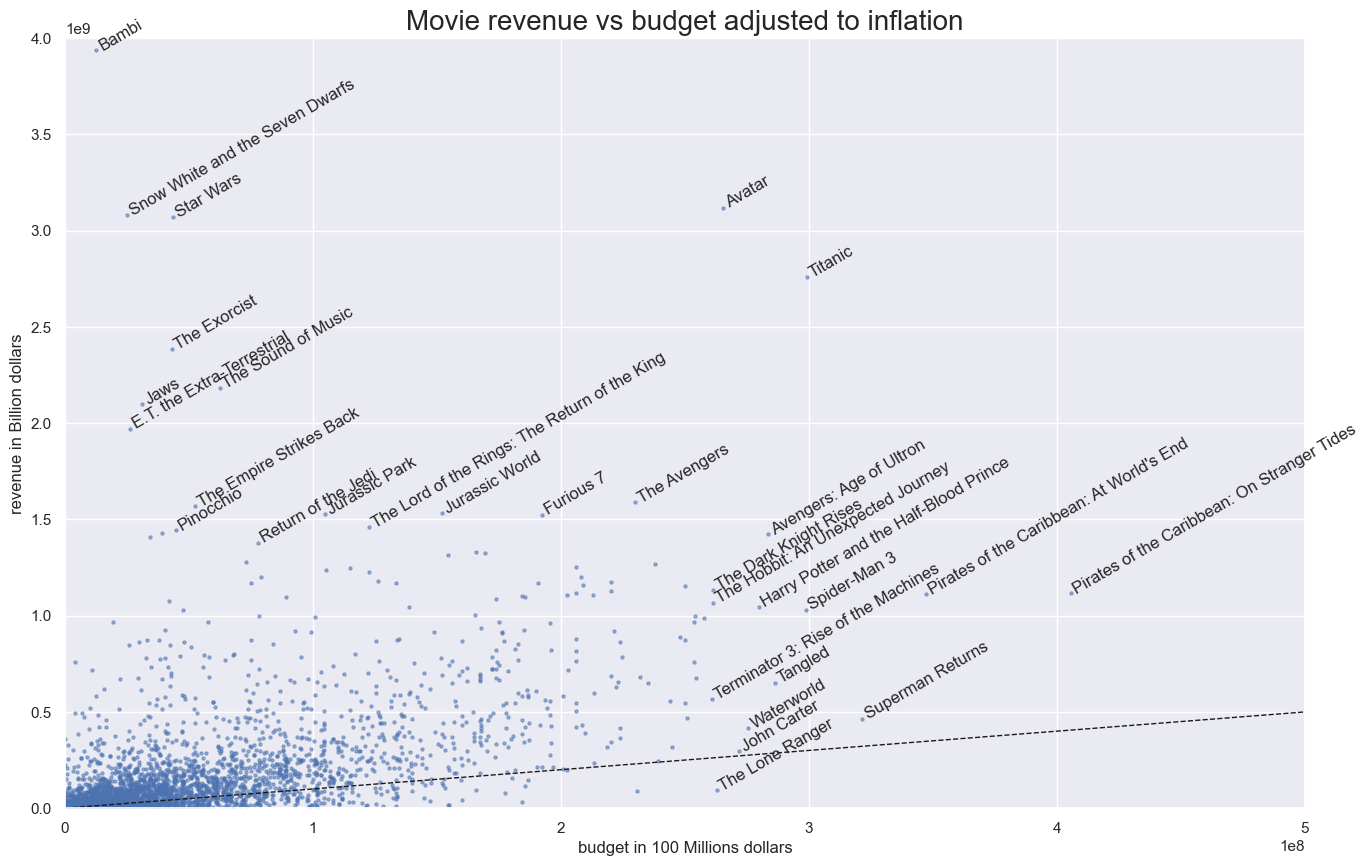

In [52]:
pos_budg=movie_df[movie_df["budget_adjusted"]>0]
x=pos_budg["budget_adjusted"]
y=pos_budg["revenue_adjusted"]
fig,ax=plt.subplots(figsize=(16,10))
plt.scatter(x,y,alpha=0.5,s=5)
plt.xlim(0,500000000)
plt.ylim(0,4000000000)
plt.title("Movie revenue vs budget adjusted to inflation",fontsize=20)
plt.xlabel("budget in 100 Millions dollars")
plt.ylabel("revenue in Billion dollars")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
for index , row in pos_budg.iterrows():
    x=row["budget_adjusted"]
    y=row["revenue_adjusted"]
    if((500000000>x>260000000) | (4000000000>y>1360000000)):
        title_to_annotate=row["title"]
        if((row["title"]!="The Godfather")&(row["title"]!="Fantasia")):
            plt.annotate(row["title"],xy=(x,y),rotation=30)

**Movies below the line recorded a loss**

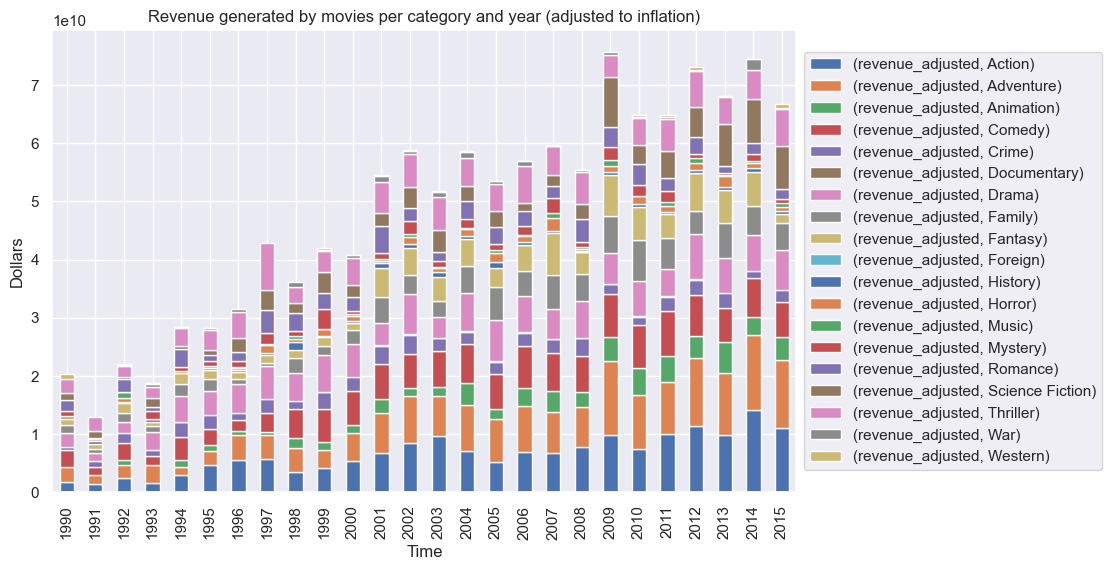

In [53]:
fig = plt.figure()
ax = plt.subplot(111)

starting_year = 1990
df_genres_revenue_year = movie_df[['genres','revenue_adjusted','year']].explode('genres').groupby(['genres','year']).sum()
df_genres_revenue_year.unstack(level=0).fillna(0).loc[starting_year:2015].plot(kind = 'bar',stacked=True, ax=ax, figsize=(12,6),legend  = True)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Revenue generated by movies per category and year (adjusted to inflation)')
plt.ylabel('Dollars')
plt.xlabel('Time')
plt.show()

#### Revenue and vote average

What is the relation between revenue and the vote_average ?

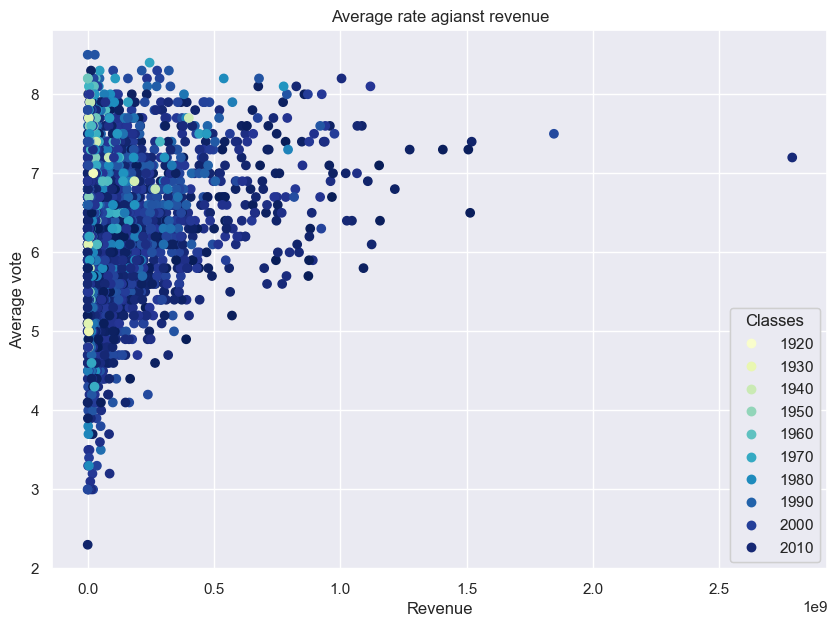

In [54]:
fig, ax = plt.subplots(figsize=(10,7))
scatter = ax.scatter( movie_df['revenue'],movie_df['vote_average'], c =movie_df['year'],cmap='YlGnBu', marker  ='o')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend1)

plt.title('Average rate agianst revenue')
plt.xlabel('Revenue')
plt.ylabel('Average vote')
plt.show()

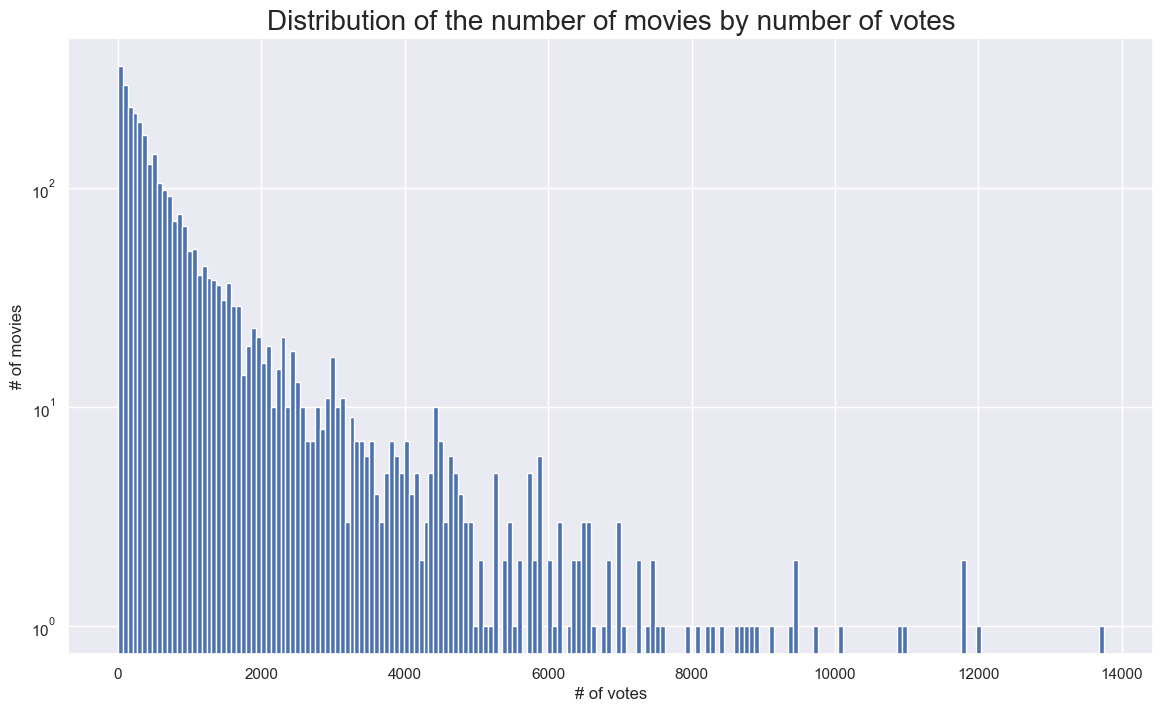

In [55]:
plt.figure(figsize=(14,8))
plt.hist(movie_df['vote_count'],200)
plt.title('Distribution of the number of movies by number of votes',fontsize=20)
plt.xlabel('# of votes')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

### Production companies

In [56]:
df_movie_prod = movie_df[['production_companies','id']].explode('production_companies')
df_movie_prod = df_movie_prod.groupby('production_companies').count().sort_values(by='id', ascending=False)
df_movie_prod.columns=["count"]
df_movie_prod

,count
production_companies,
Warner Bros.,280
Universal Pictures,272
Paramount Pictures,242
Twentieth Century Fox Film Corporation,201
Columbia Pictures,167
...,...
Hit & Run Productions,1
Hobby Films,1
Hokkaido Broadcasting Co.,1


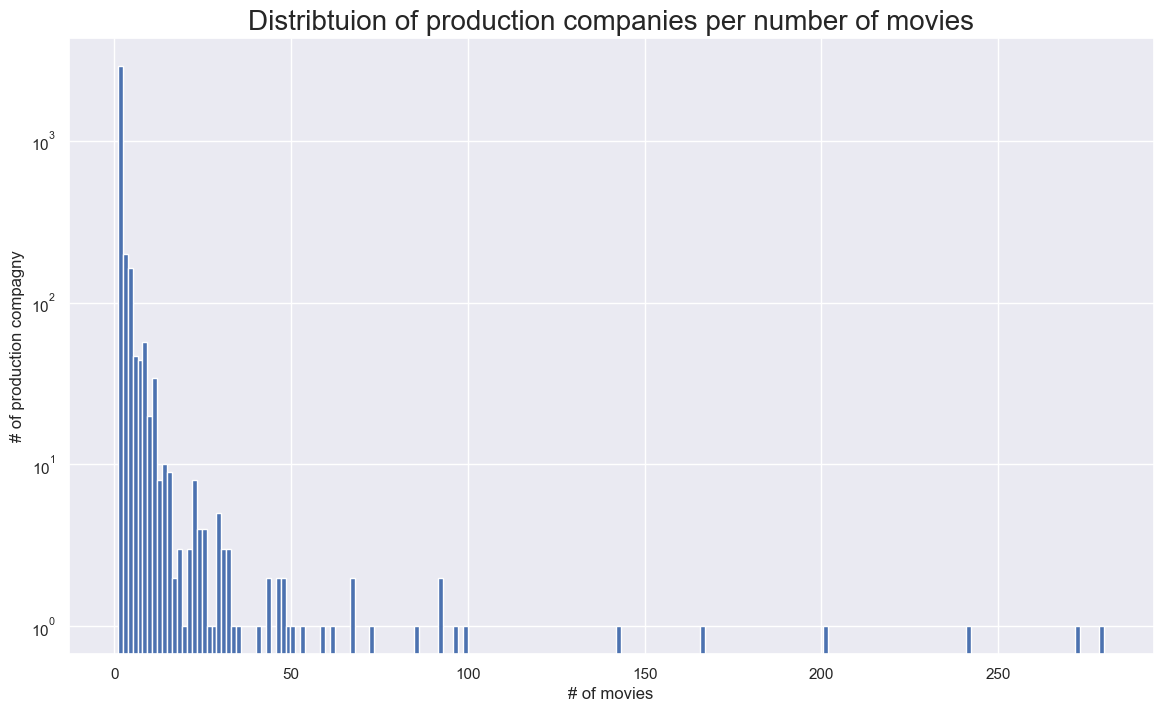

In [57]:

plt.figure(figsize=(14,8))
plt.hist(df_movie_prod['count'],200)
plt.title('Distribtuion of production companies per number of movies',fontsize=20)
plt.ylabel('# of production compagny')
plt.xlabel('# of movies')
plt.yscale("log")
plt.show()

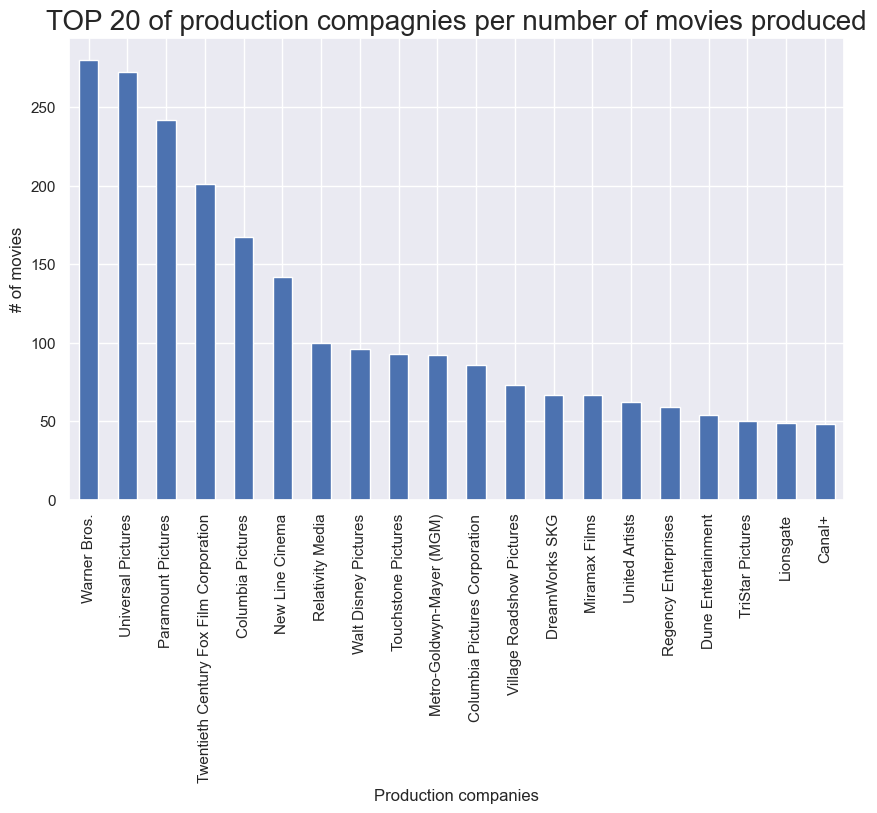

In [58]:
df_movie_prod[:20].plot(kind ="bar",figsize=(10,6),legend = False)
plt.title('TOP 20 of production compagnies per number of movies produced',fontsize=20)
plt.xlabel("Production companies")
plt.ylabel("# of movies")
plt.show()

Let's look in terms of revenue.

In [59]:
df_movie_revenue = movie_df[['production_companies','revenue']].explode('production_companies')

In [60]:
df_movie_revenue_sum = df_movie_revenue.groupby('production_companies').sum().sort_values(by='revenue', ascending=False)
df_movie_revenue_sum.head()

,revenue
production_companies,
Warner Bros.,48822074563
Universal Pictures,42394603321
Paramount Pictures,40514725671
Twentieth Century Fox Film Corporation,39136501776
Columbia Pictures,28526534603


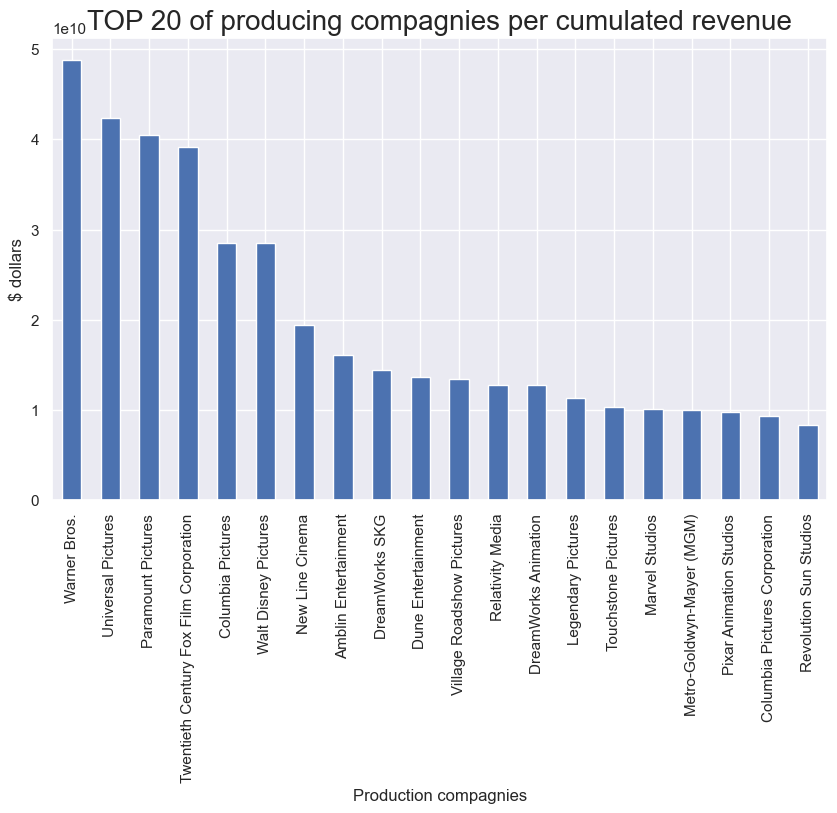

In [61]:
df_movie_revenue_sum[:20].plot(kind ="bar",figsize=(10,6),legend = False)
plt.title('TOP 20 of producing compagnies per cumulated revenue',fontsize=20)
plt.xlabel("Production compagnies")
plt.ylabel("$ dollars")
plt.show()

In [62]:
df_movie_revenue_avg = df_movie_revenue.groupby('production_companies').mean().sort_values(by='revenue', ascending=False)
df_movie_revenue_avg.head()

,revenue
production_companies,
Québec Production Services Tax Credit,1.506249e+09
Abu Dhabi Film Commission,1.506249e+09
"Colorado Office of Film, Television & Media",1.506249e+09
Prime Focus,1.405404e+09
Vita-Ray Dutch Productions (III),1.153304e+09


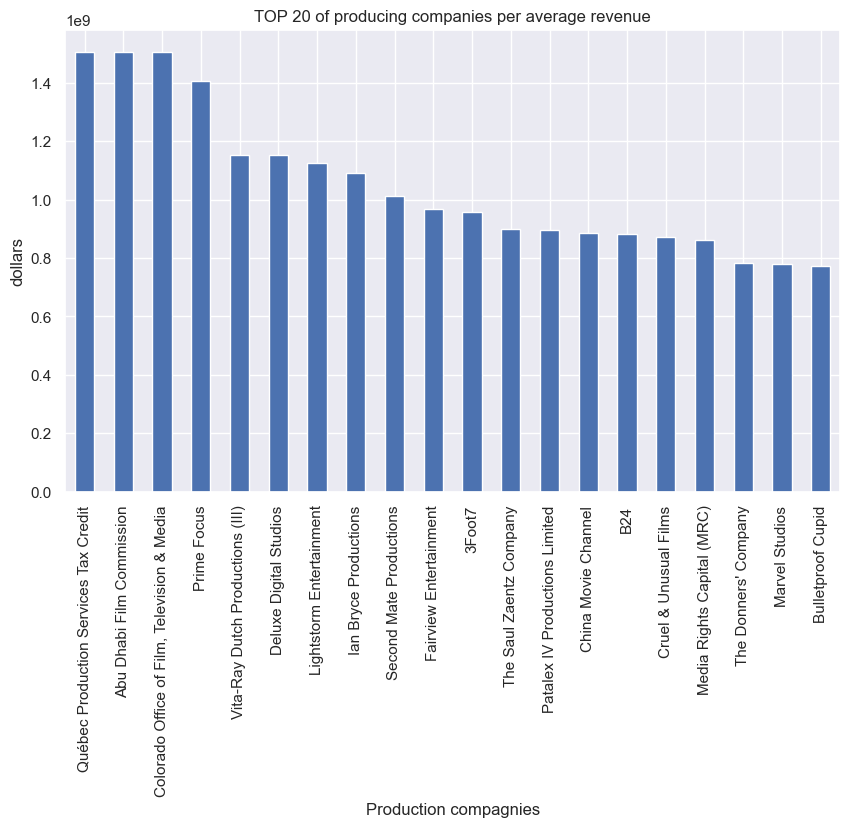

In [63]:
df_movie_revenue_avg[:20].plot(kind ="bar",figsize=(10,6),legend = False)
plt.title('TOP 20 of producing companies per average revenue')
plt.xlabel("Production compagnies")
plt.ylabel("dollars")
plt.show()

For the model we would like to only keep the most important companies as it's a categorical features and we will have one new dimension per value.

In [64]:
#we only keep the 20 top with the most movies, can try with df_movie_revenue_sum ?
interesting_prod = df_movie_prod.head(20).index.values
movie_df.production_companies = movie_df.production_companies.apply(lambda x :[prod for prod in x if prod in interesting_prod])
movie_df.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,year,day_of_year,month,budget_adjusted,revenue_adjusted
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Twentieth Century Fox Film Corporation, Dune ...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,[Walt Disney Pictures],...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,139,5,3.472625e+08,1.112398e+09
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bondâ€™s past sends him...,107.376788,[Columbia Pictures],...,Released,A Plan No One Escapes,Spectre,6.3,4466,2015,299,10,2.480907e+08,8.917844e+08
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,[Warner Bros.],...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012,198,7,2.613385e+08,1.134145e+09
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012,67,3,2.717920e+08,2.970259e+08


### Keywords

In [65]:
movie_df.explode('keywords').groupby(['keywords'])[['id']].count().sort_values(by='id', ascending=False)[:10]

,id
keywords,
duringcreditsstinger,270
based on novel,175
woman director,165
aftercreditsstinger,148
murder,143
dystopia,130
independent film,127
violence,126
3d,91


In [66]:
interesting_keywords = ["woman director","independent film","based on novel","murder","violence","sex",
                      "nudity","superhero","biography","dystopia", "violence","revenge", "sport","teenager",
                        "3d","love","sequel"]

movie_df.keywords = movie_df.keywords.apply(lambda x :[keyword for keyword in x if keyword in interesting_keywords ])
display(movie_df.keywords)

0                           [3d]
1                             []
2       [based on novel, sequel]
3                    [superhero]
4           [based on novel, 3d]
                  ...           
4773                          []
4788          [independent film]
4792    [based on novel, murder]
4796          [independent film]
4798                          []
Name: keywords, Length: 3209, dtype: object

### Production countries

In [67]:
df_prod_countries_count = movie_df.explode('production_countries')['production_countries'].value_counts()
df_prod_countries_count.head(10)

production_countries
United States of America    2893
United Kingdom               431
Germany                      232
France                       196
Canada                       161
Australia                     77
Italy                         48
Spain                         43
Japan                         40
China                         37
Name: count, dtype: int64

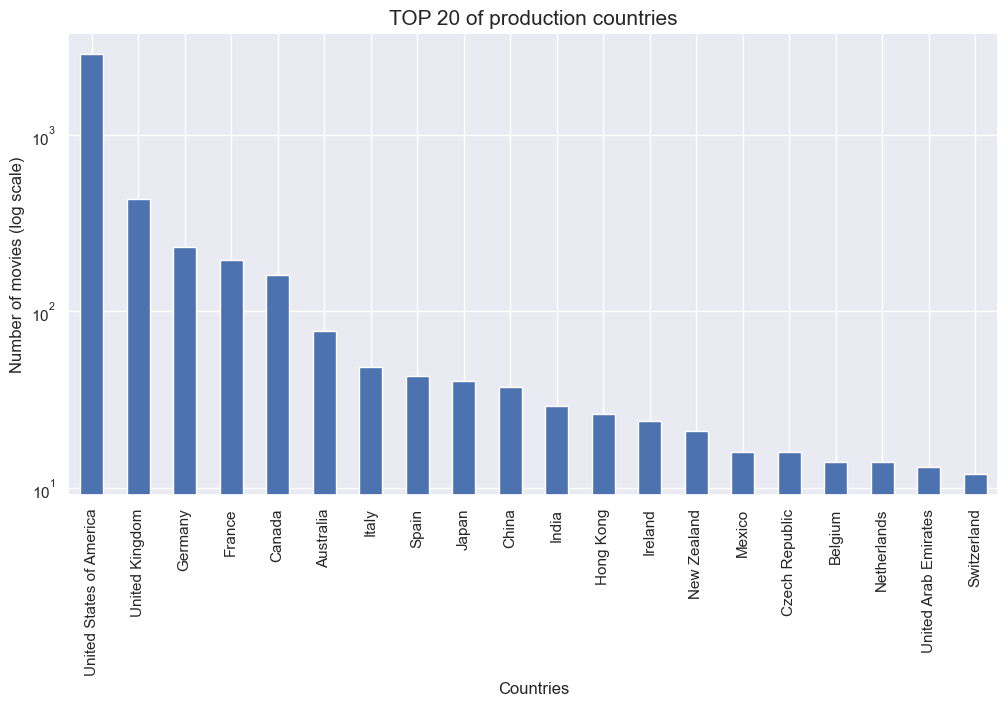

In [68]:
df_prod_countries_count[:20].plot(kind ="bar",figsize=(12,6),legend = False)
plt.title('TOP 20 of production countries',fontsize=15)
plt.ylabel("Number of movies (log scale)")
plt.xlabel("Countries")
plt.yscale("log")
plt.show()

In [69]:
#we only keep the 10 top countries with the most movies, 
interesting_prod_countries = df_prod_countries_count.head(10).index.values
display(interesting_prod_countries)
movie_df.production_countries = movie_df.production_countries.apply(lambda x :[prod for prod in x if prod in interesting_prod_countries])
movie_df.production_countries

array(['United States of America', 'United Kingdom', 'Germany', 'France',
       'Canada', 'Australia', 'Italy', 'Spain', 'Japan', 'China'],
      dtype=object)

0       [United States of America, United Kingdom]
1                       [United States of America]
2       [United Kingdom, United States of America]
3                       [United States of America]
4                       [United States of America]
                           ...                    
4773                    [United States of America]
4788                    [United States of America]
4792                                       [Japan]
4796                    [United States of America]
4798                    [United States of America]
Name: production_countries, Length: 3209, dtype: object

### Spoken languages

In [70]:
df_lang_count = movie_df.explode('spoken_languages')['spoken_languages'].value_counts()
df_lang_count.head(10)

spoken_languages
English      3116
Français      303
Español       270
Deutsch       178
Pусский       147
Italiano      142
日本語            82
普通话            79
العربية        55
Português      46
Name: count, dtype: int64

C:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26222 (\N{CJK UNIFIED IDEOGRAPH-666E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages

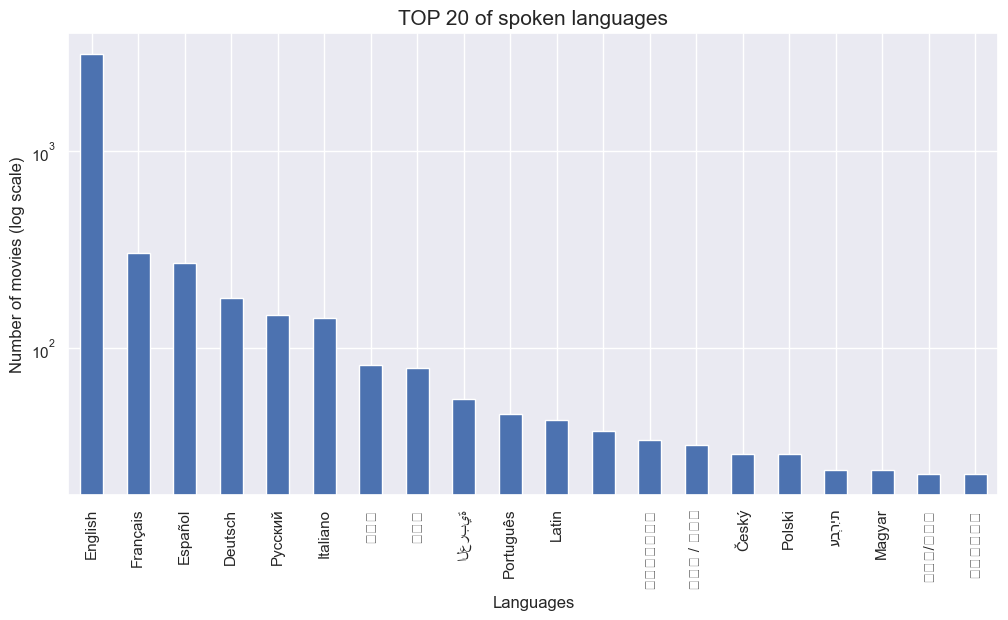

In [71]:
df_lang_count[:20].plot(kind ="bar",figsize=(12,6),legend = False)
plt.title('TOP 20 of spoken languages',fontsize=15)
plt.ylabel("Number of movies (log scale)")
plt.xlabel("Languages")
plt.yscale("log")
plt.show()

In [72]:
#we only keep the 10 top countries with the most movies
interesting_lang = df_lang_count.head(5).index.values
movie_df.spoken_languages = movie_df.spoken_languages.apply(lambda x :[lang for lang in x if lang in interesting_lang])
movie_df.spoken_languages

0                          [English, Español]
1                                   [English]
2       [Français, English, Español, Deutsch]
3                                   [English]
4                                   [English]
                        ...                  
4773                                [English]
4788                                [English]
4792                                       []
4796                                [English]
4798                                [Español]
Name: spoken_languages, Length: 3209, dtype: object

### original_language

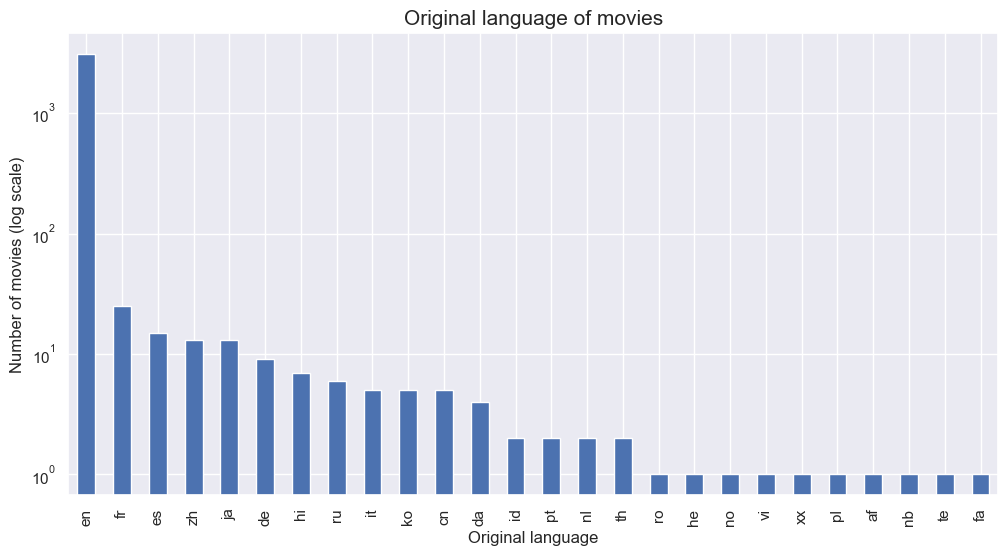

In [73]:
fig , ax =plt.subplots(figsize=(12,6))
# display(movie_df.original_language)
movie_df.original_language.value_counts().plot(kind='bar')

plt.yscale("log")
plt.title("Original language of movies",fontsize=15)
plt.xlabel("Original language")
plt.ylabel("Number of movies (log scale)")
plt.show()

We will not keep it as feature.

### status

In [74]:
movie_df.status.value_counts()

status
Released           3208
Post Production       1
Name: count, dtype: int64

We will not keep it as feature.

## ML model

We would like to develop a model to predict movie's revenue.

### One hot encoding

In [75]:
movie_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'year', 'day_of_year', 'month', 'budget_adjusted',
       'revenue_adjusted'],
      dtype='object')

In [76]:
features_kept = ['title','keywords','budget','genres','popularity', 'production_companies', 
                'production_countries', 'year' ,'day_of_year','month','revenue', 'runtime', 'spoken_languages',
                'vote_average', 'vote_count',]

data = movie_df[features_kept].set_index('title')
data=data[data["year"]>1960]
data.head()

,keywords,budget,genres,popularity,production_companies,production_countries,year,day_of_year,month,revenue,runtime,spoken_languages,vote_average,vote_count
title,,,,,,,,,,,,,,
Avatar,[3d],237000000,"[Action, Adventure, Fantasy, Science Fiction]",150.437577,"[Twentieth Century Fox Film Corporation, Dune ...","[United States of America, United Kingdom]",2009,344,12,2787965087,162.0,"[English, Español]",7.2,11800
Pirates of the Caribbean: At World's End,[],300000000,"[Adventure, Fantasy, Action]",139.082615,[Walt Disney Pictures],[United States of America],2007,139,5,961000000,169.0,[English],6.9,4500
Spectre,"[based on novel, sequel]",245000000,"[Action, Adventure, Crime]",107.376788,[Columbia Pictures],"[United Kingdom, United States of America]",2015,299,10,880674609,148.0,"[Français, English, Español, Deutsch]",6.3,4466
The Dark Knight Rises,[superhero],250000000,"[Action, Crime, Drama, Thriller]",112.312950,[Warner Bros.],[United States of America],2012,198,7,1084939099,165.0,[English],7.6,9106
John Carter,"[based on novel, 3d]",260000000,"[Action, Adventure, Science Fiction]",43.926995,[Walt Disney Pictures],[United States of America],2012,67,3,284139100,132.0,[English],6.1,2124


In [77]:
data.shape

(3145, 14)

We explode the lists that we have and transform them as dummy variable.

In [78]:
col_to_explode = ['genres','keywords','production_companies','production_countries','spoken_languages']


for c in col_to_explode: 
    data_exploded = data.explode(c)
    # display(data_exploded)
    dummies = pd.get_dummies(data_exploded[c]).groupby('title').sum()
    # dummies = pd.get_dummies(data_exploded[c]).groupby(level=0).sum()
    data = dummies.join(data).drop(columns = c)

display(data.head(5))
data.shape


,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,Western,budget,popularity,year,day_of_year,month,revenue,runtime,vote_average,vote_count
title,,,,,,,,,,,,,,,,,,,,,
9,0,1,0,0,0,0,0,0,0,0,...,0,30000000,55.806402,2009,231,8,48428063,79.0,6.6,1262
21,0,1,0,0,0,0,0,0,0,0,...,0,35000000,45.149948,2008,87,3,69823199,123.0,6.5,1375
42,0,0,0,0,0,0,0,0,0,0,...,0,40000000,31.884559,2013,102,4,95020213,128.0,6.8,787
54,0,1,0,0,0,0,0,0,0,0,...,0,13000000,11.880899,1998,240,8,16757163,106.0,5.5,135
300,0,1,0,0,0,0,0,0,0,0,...,0,65000000,65.197968,2006,343,12,422610419,117.0,7.0,4997


(3145, 79)

In [79]:
data_no_cast=data.copy()

## Revenue prediction

### Baseline
Our metric will be the adjusted R squared, our baseline will be predicting all movies revenues as the mean of revenues in the training set. 

In [80]:
seed=42
split_size=0.2

In [81]:
def preprocess(data,y,x_to_drop,seed=seed,split_size=split_size):

    data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    y=data[y]
    X=data.drop(columns=x_to_drop)
    X = sm.add_constant(X)
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X)
    X = pd.DataFrame(X_transformed, columns = X.columns,index=y.index)

    # splitting the data
    return train_test_split(X, y, test_size=split_size, random_state=seed)

In [82]:
def adjusted_r_2(y_test,y_pred,n,p):
    r2=r2_score(y_test,y_pred)
    return 1-(1-r2)*(n-1)/(n-p-1)

In [83]:
X_train, X_test, y_train, y_test=preprocess(data_no_cast,"revenue",["revenue","vote_count","vote_average","popularity"])

In [84]:
data_no_cast.shape

(3145, 79)

In [85]:
display(X_train)
X_train.shape


,const,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,...,Romance,Science_Fiction,Thriller,War,Western,budget,year,day_of_year,month,runtime
title,,,,,,,,,,,,,,,,,,,,,
The Other Woman,0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,2.186607,-0.396359,-0.645992,-0.191273,-0.128388,-0.036936,1.054990,-0.883591,-0.884404,-0.077192
Escape Plan,0.0,4.132156,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,-0.457330,-0.396359,1.548008,-0.191273,-0.128388,0.187653,0.960349,0.832829,0.900484,0.213259
Mission to Mars,0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,-0.457330,2.522962,-0.645992,-0.191273,-0.128388,1.086011,-0.269992,-1.234676,-1.181885,0.164851
John Carter,0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,-0.457330,2.522962,-0.645992,-0.191273,-0.128388,4.904030,0.865707,-1.263934,-1.181885,1.036204
Aquamarine,0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,6.312223,-0.232281,-0.109109,-0.257805,...,2.186607,-0.396359,-0.645992,-0.191273,-0.128388,-0.665786,0.297858,-1.312695,-1.181885,-0.319235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Witness,0.0,4.132156,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,2.186607,-0.396359,1.548008,-0.191273,-0.128388,-0.665786,-1.689616,-1.537000,-1.479366,0.116442
House of 1000 Corpses,0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,-0.457330,-0.396359,-0.645992,-0.191273,-0.128388,-0.778081,0.013933,-0.932353,-0.884404,-1.045362
"I, Robot",0.0,-0.242004,0.171639,-0.305209,-0.32353,-0.220642,-0.158423,-0.232281,-0.109109,-0.257805,...,-0.457330,2.522962,-0.645992,-0.191273,-0.128388,1.759779,0.108575,0.003876,0.008040,0.213259


(2516, 76)

In [86]:
y_pred=np.ones(y_test.shape) * np.mean(y_train)
print("Baseline")
adjusted_r_2(y_test,y_pred,len(y_train),1)

Baseline


-0.005006188902910713

### Regression

#### OLS

In [87]:
y_pred=sm.OLS(y_train, X_train).fit().predict(X_test)
print("OLS Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))

OLS Score: -0.0514855742892526


#### Ridge Regression

Ridge Regression Score: 0.5021257489233071


Text(0, 0.5, 'Mean Squared Error')

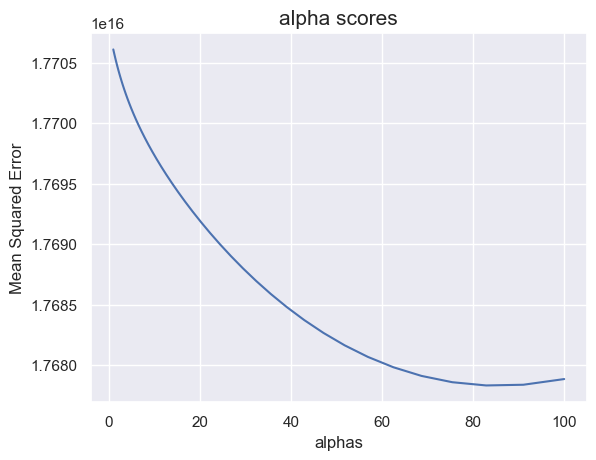

In [88]:
alphas=np.logspace(0,2,50)
clf = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
plt.plot(alphas,np.apply_along_axis(np.mean,0,clf.cv_values_))
plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

#### XGboost

In [89]:

regressor = XGBRegressor(colsample_bytree= 1, max_depth= 4, min_child_weight= 2,
                         subsample = 0.7, objective='reg:squarederror',verbosity=1,learning_rate=0.1,random_state=42)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print("XGBoost retained {} features".format(sum(regressor.feature_importances_>0)))
print("XGBoost Score:",adjusted_r_2(y_test, y_pred,len(y_train),sum(regressor.feature_importances_>0)))

XGBoost retained 68 features
XGBoost Score: 0.5415936109093313


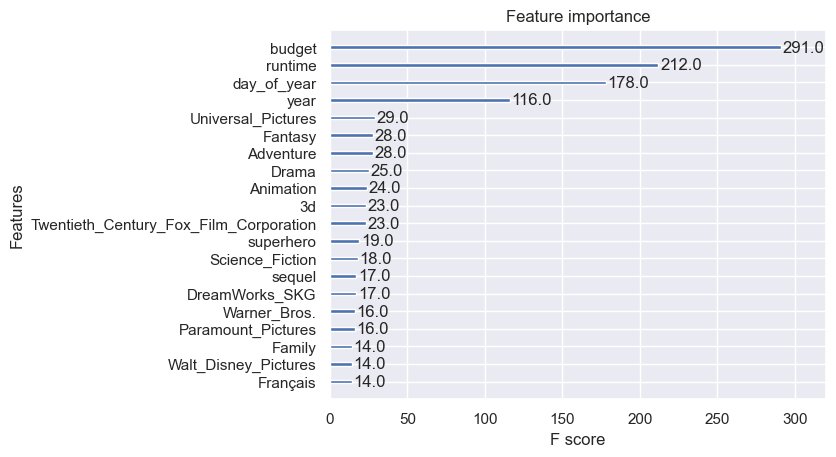

In [90]:

plot_importance(regressor,max_num_features = 20)
plt.show()

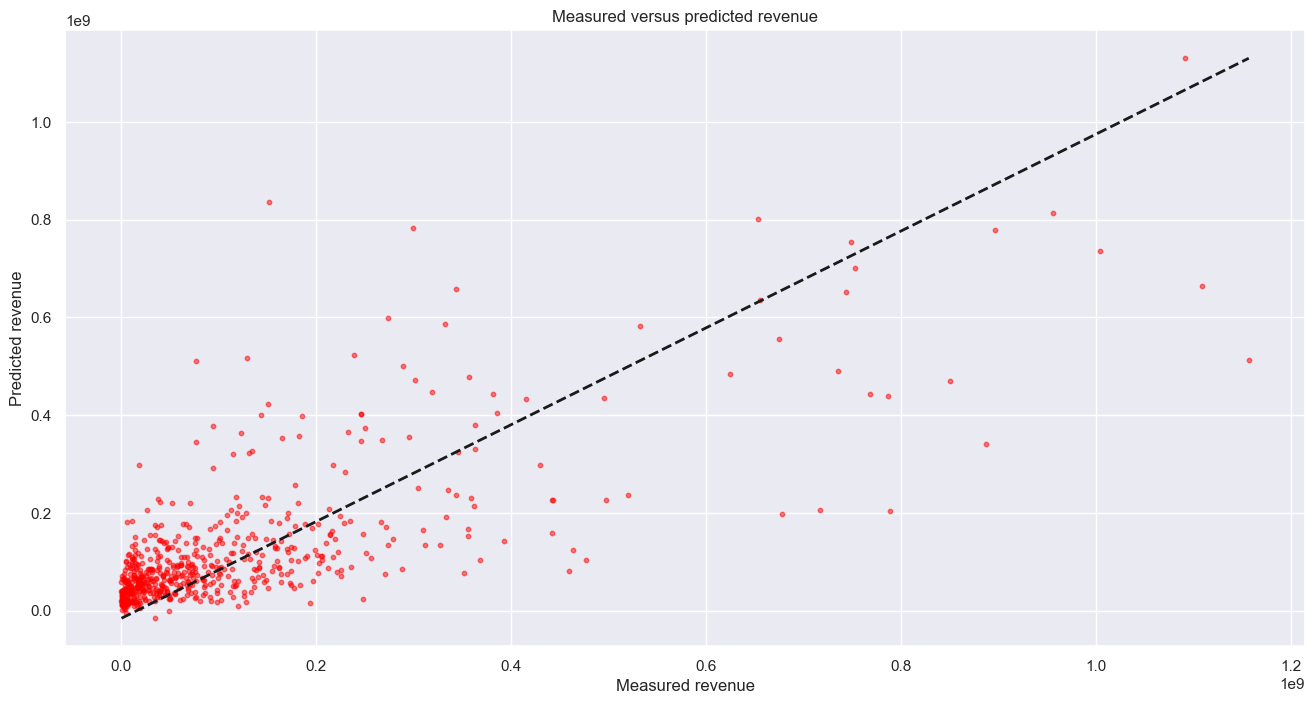

In [91]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test, y_pred,alpha=0.5,s=10,c="red")
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')
plt.title('Measured versus predicted revenue')    
plt.show()

## Rating prediction

### Baseline

In [93]:
X_train, X_test, y_train, y_test=preprocess(data_no_cast,"vote_average",["revenue","vote_count","vote_average","popularity"])

In [94]:
data_no_cast.shape

(3145, 79)

In [95]:
X_train.shape

(2516, 76)

In [96]:
y_pred=np.ones(y_test.shape) * np.mean(y_train)
y_pred=list(map(lambda x: round(x,1),y_pred))
print("Baseline")
adjusted_r_2(y_test,y_pred,len(y_train),1)

Baseline


-0.0014193640435460342

### Regression

#### OLS

In [97]:
y_pred=sm.OLS(y_train, X_train).fit().predict(X_test)
print("OLS Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))

OLS Score: -56.0975988176592


#### Ridge Regression

Ridge Regression Score: 0.2211313314350981


Text(0, 0.5, 'Mean Squared Error')

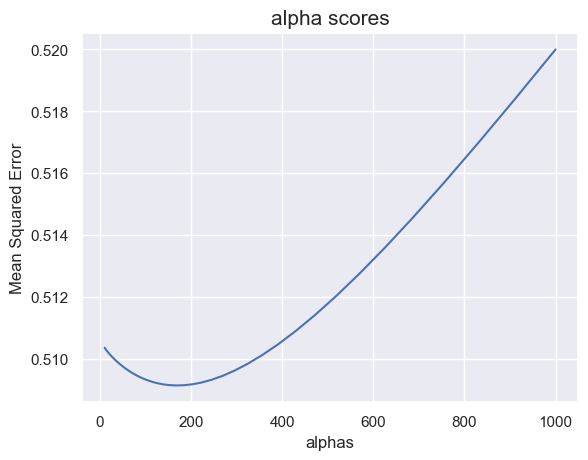

In [98]:
alphas=np.logspace(1,3,50)
clf = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
plt.plot(alphas,np.apply_along_axis(np.mean,0,clf.cv_values_))
plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

#### XGboost

In [99]:
regressor = XGBRegressor(colsample_bytree= 1, max_depth= 6, min_child_weight= 2,
                         subsample = 0.9, objective='reg:squarederror',verbosity=1,learning_rate=0.07,random_state=42)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print("XGBoost retained {} features".format(sum(regressor.feature_importances_>0)))
print("XGBoost Score:",adjusted_r_2(y_test, y_pred,len(y_train),sum(regressor.feature_importances_>0)))

XGBoost retained 74 features
XGBoost Score: 0.2886171326114514


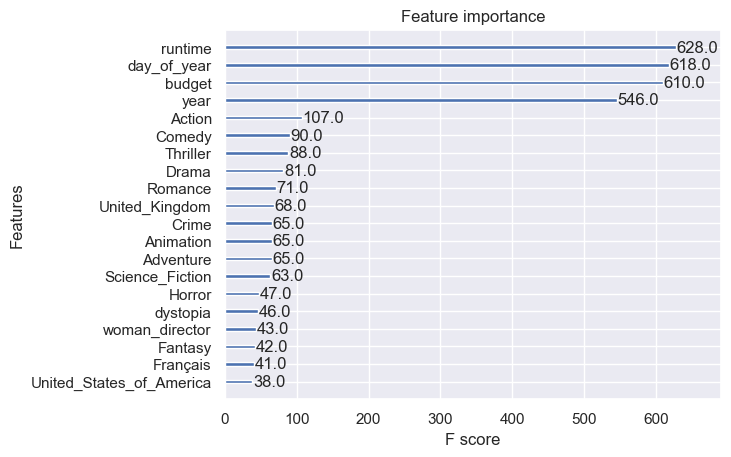

In [100]:

plot_importance(regressor,max_num_features = 20)
plt.show()

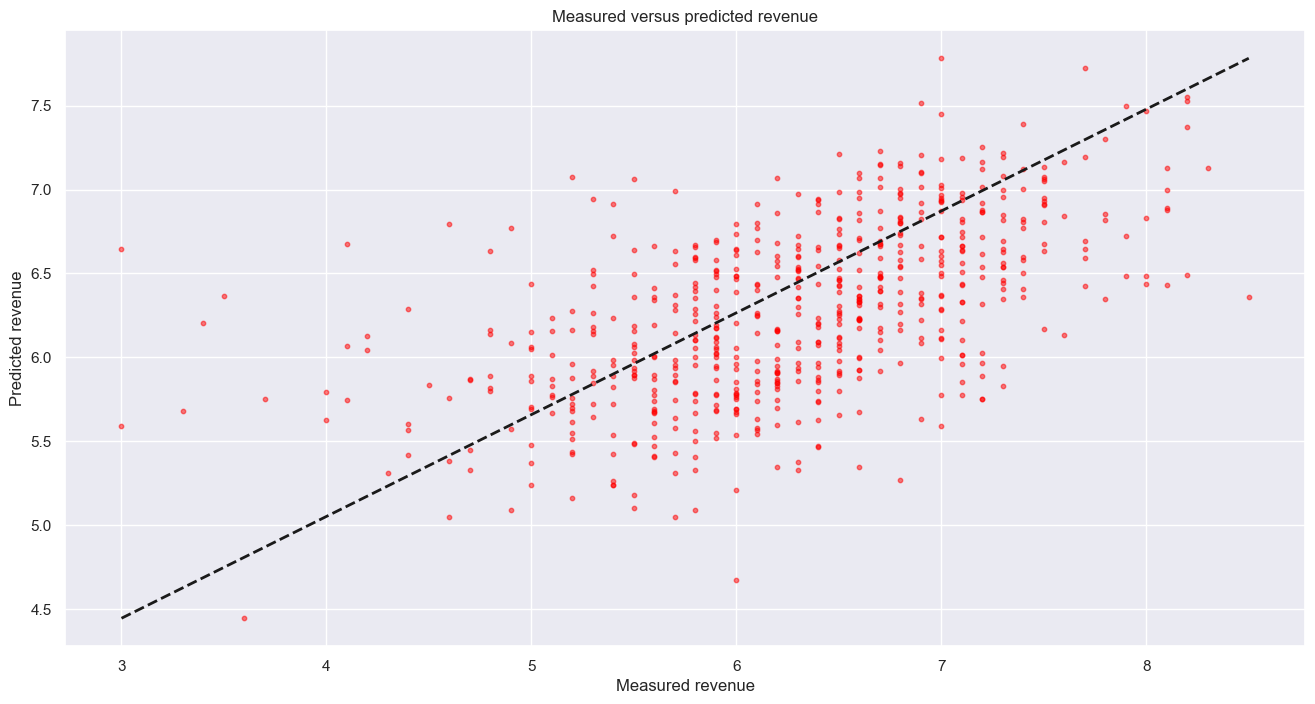

In [101]:
fig, ax = plt.subplots(figsize=(16,8))
y_pred=np.asarray(y_pred)
ax.scatter(y_test, y_pred,alpha=0.5,s=10,c="red")
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')
plt.title('Measured versus predicted revenue')    
plt.show()